This iPython Notebook walks through the process of injesting cyclical multivariate timeseries data of varying samples per variable and training a 1-D convolutional neural network to predict system condition

begin by loading the data into numpy arrays

In [1]:
import numpy as np
ps1 = np.loadtxt("./data/PS1.txt")
ps2 = np.loadtxt("./data/PS2.txt")
ps3 = np.loadtxt("./data/PS3.txt")
ps4 = np.loadtxt("./data/PS4.txt")
ps5 = np.loadtxt("./data/PS5.txt")
ps6 = np.loadtxt("./data/PS6.txt")
eps1 = np.loadtxt("./data/EPS1.txt")
fs1 = np.loadtxt("./data/FS1.txt")
fs2 = np.loadtxt("./data/FS2.txt")
ts1 = np.loadtxt("./data/TS1.txt")
ts2 = np.loadtxt("./data/TS2.txt")
ts3 = np.loadtxt("./data/TS3.txt")
ts4 = np.loadtxt("./data/TS4.txt")
vs1 = np.loadtxt("./data/VS1.txt")
ce = np.loadtxt("./data/CE.txt")
cp = np.loadtxt("./data/CP.txt")
se = np.loadtxt("./data/SE.txt")

data_list = [ps1, ps2, ps3, ps4, ps5, ps6, eps1, fs1, fs2, ts1, ts2, ts3, ts4, vs1, ce, cp, se]

verify the data was loaded correctly by printing the shape and plotting the first row of each array

(2205, 6000)


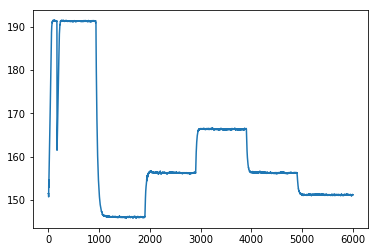

(2205, 6000)


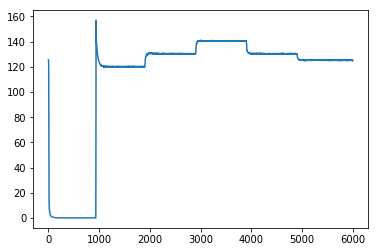

(2205, 6000)


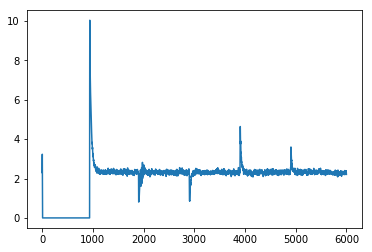

(2205, 6000)


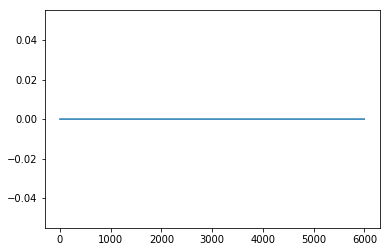

(2205, 6000)


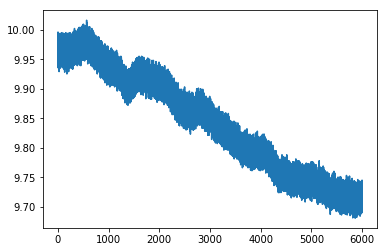

(2205, 6000)


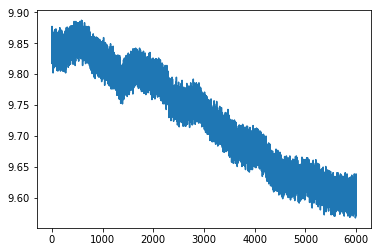

(2205, 6000)


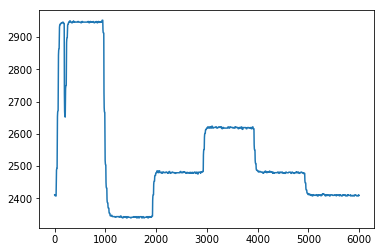

(2205, 600)


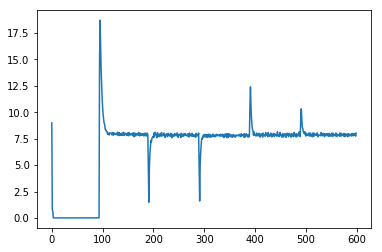

(2205, 600)


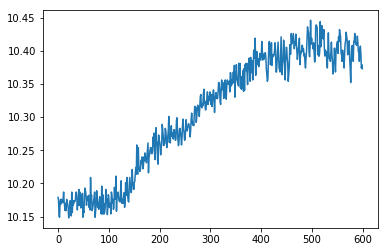

(2205, 60)


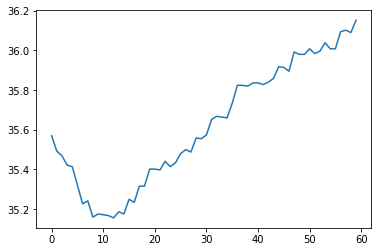

(2205, 60)


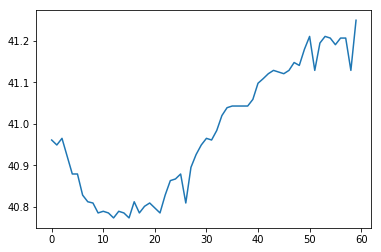

(2205, 60)


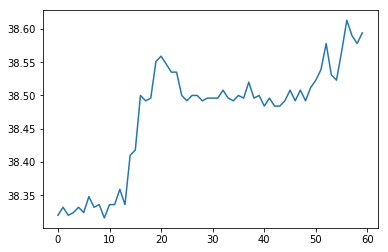

(2205, 60)


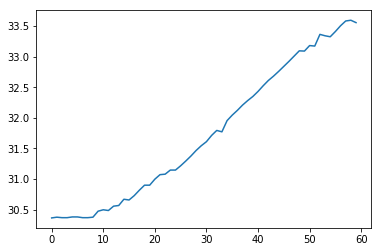

(2205, 60)


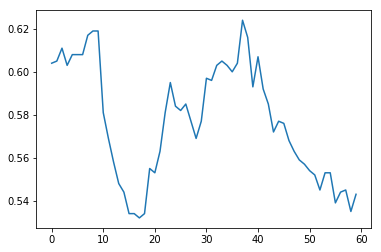

(2205, 60)


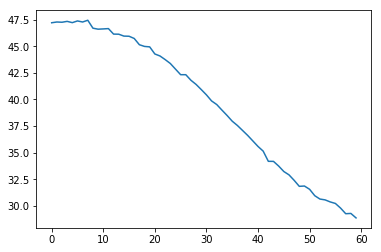

(2205, 60)


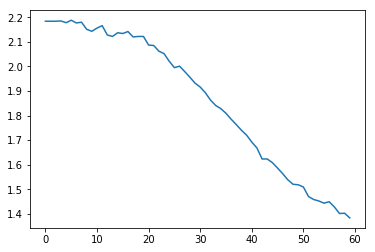

(2205, 60)


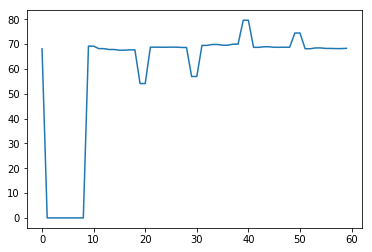

In [2]:
import matplotlib.pyplot as plt
for array in data_list:
    print(array.shape)
    plt.plot(array[0])
    plt.show()

Normalize the data between -1 and 1 with min/max normalization

In [3]:

data_mins = [data.min() for data in data_list]
data_maxes = [data.max() for data in data_list]

transformed_data = [2 * (data - data_min) / (data_max - data_min) - 1
                    for data, data_min, data_max in zip(data_list, data_mins, data_maxes)]

Randomly partition a sample from the data to be a validation set. The validation set is not to be used in training

In [4]:
import random

validation_size = transformed_data[0].shape[0] // 10

train_data_indx = list(range(transformed_data[0].shape[0]))
val_data_indx = []
for _ in range(validation_size):
    val_data_indx.append(train_data_indx.pop(random.randrange(len(train_data_indx))))
    
    

Load in the label data and normalize it with min/max normalization

In [5]:
label_data = np.loadtxt("./data/profile.txt")
label_mins = label_data.min(axis=0)
label_maxes = label_data.max(axis=0)

label_data = (label_data - label_mins) / (label_maxes - label_mins)

In [7]:
import tensorflow as tf
import importlib
import models
importlib.reload(models)
from models import *

Now train the network

In [ ]:
data_sizes = [array.shape[1] for array in transformed_data]
label_size = label_data.shape[1]
learning_rate = 1e-6
epoch_count = 500
batch_size = 1
out_dim = label_data.shape[1]

train_graph = tf.Graph()
with train_graph.as_default():
    # initialize tf variables
    inputs, labels, lr = cnn1d_inputs(data_sizes, label_size)
    logits, predictions = cnn1d(inputs, label_size)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    model_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    batch_i = 0
    train_loss_data = []
    val_loss_data = []
    train_loss = None
    val_loss = None
    
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())
        print("total trainable parameters:", 
              np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))

        for epoch_i in range(epoch_count):
            batch_i = 0
            while (batch_i + 1) * batch_size <= len(train_data_indx):
                # extract a batch from the training data and labels
                indx_start = batch_i*batch_size
                indx_end = (batch_i+1)*batch_size
                data_batch = [array[train_data_indx][indx_start:indx_end] for array in transformed_data]
                labels_batch = label_data[train_data_indx][indx_start:indx_end]

                # run model optimizer on the batch
                _ = sess.run(model_opt, feed_dict={inputs:data_batch, labels:labels_batch})

                if batch_i % 10 == 0:
                    # compute and record the training loss
                    train_loss = loss.eval({inputs:data_batch, labels:labels_batch})
                    train_loss_data.append(train_loss)

                    # compute and record the validation loss
                    val_data = [array[val_data_indx][:] for array in transformed_data]
                    val_loss = loss.eval({inputs:val_data, labels:label_data[val_data_indx][:]})
                    val_loss_data.append(val_loss)

                    # print training losses
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{} ...".format(batch_i, len(train_data_indx)//batch_size),
                          "Training Loss: {:.4f}...".format(train_loss),
                          "Validation Loss: {:.4f}".format(val_loss),
                          end="\r",)                    
                batch_i += 1

        print("\nFinished training!",
              "Training Loss: {}...".format(train_loss),
              "Validation Loss: {}".format(val_loss))
        train, = plt.plot(train_loss_data, label="Training Loss")
        val, = plt.plot(val_loss_data, label="Validation Loss")
        plt.legend(handles=[train, val])
        plt.show()
        
        saver = tf.train.Saver()
        saver.save(sess, './cnn1d/')

        

In [ ]:
with train_graph.as_default():
    inputs, labels, lr = cnn1d_inputs(data_sizes, label_size)
    _, predictions = cnn1d(inputs, label_size, is_train=False)
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, './cnn1d/')
        
        val_data = [array[val_data_indx][:] for array in transformed_data]
        y_ = sess.run(predictions, {inputs:val_data})
        y = label_data[val_data_indx][:]
        #print(y)
        print("mean absolute error: ", np.mean(np.abs(y_ - y)))

Since the labels are normalized, we can infer the network's validation accuracy to be 